# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is as follows:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):*
- Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP/CF NRT** often if no corrections, offsets or time bounds are applied. Occasionally some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP/CF Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process



## Example below is for 4-beam ADCP but the workflow is similar for all ADCP's with this output format.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [74]:
import yaml
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import EcoFOCIpy.io.adcp_parser as adcp_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config
import EcoFOCIpy.math.geotools as geotools

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [75]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2023/Moorings/23kup1a/'

In [76]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/adcp/'
instrument = 'RDI 300 kHz ADCP 25779'
serial = '25779'
mooring_meta_file = user_data_dir+'logs/23KUP-1A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/adcp.yaml'
inst_shortname = ''
###############################################################

#init and load data : there are usually 5 files associated with ADCP data
adcp_wop = adcp_parser.adcp(serialno=serial,depdir=datafile)
adcp_pg_data = adcp_wop.load_pg_file() 
adcp_ein_data = adcp_wop.load_ein_file() 
adcp_scal_data = adcp_wop.load_scal_file() 
adcp_vel_data = adcp_wop.load_vel_file() 

#load report file
adcp_rpt = adcp_wop.load_rpt_file()

In [77]:
adcp_scal_data.sample()

,unknown,temperature,heading,pitch,roll,heading_stdev,pitch_stdev,roll_stdev
date_time,,,,,,,,
2023-05-23 16:30:00,1,0.19,358.78,-1.49,0.14,2,1,1


In [78]:
adcp_pg_data.sample()

,bin,pg3beam-good,pgtransf-good,pg1beam-bad,pg4beam-good
date_time,,,,,
2023-07-15 09:00:00,1,0,0,0,100


In [79]:
adcp_rpt[1]

{'numofbins': 24.0, 'bin_length': 200.0, 'distance': 419.0}

## Add Deployment meta information

Load for future use, but in case of ADCP early loading allows declination correction based on recorded location

In [80]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [81]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'RDI 300 kHz ADCP',
 'SerialNo': '25779',
 'DesignedDepth': 40.0,
 'ActualDepth': 41.0,
 'PreDeploymentNotes': 'Brand new instrument, 0.5 deg error, 30 min sampling, 2m bins',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': 'y'}

In [82]:
print(f"Deployment Lat: {mooring_config['Deployment']['DeploymentLatitude']}")
print(f"Deployment Lon: {mooring_config['Deployment']['DeploymentLongitude']}")
print(f"Deployment Date: {mooring_config['Deployment']['DeploymentDateTimeGMT'].date()}")

#some parsing/cleaning for functions
latlon_dec = geotools.latlon_convert(mooring_config['Deployment']['DeploymentLatitude'],
                        mooring_config['Deployment']['DeploymentLongitude'])
dep_date = mooring_config['Deployment']['DeploymentDateTimeGMT'].date()

Deployment Lat: 57 43.016 N
Deployment Lon: 163 43.155 W
Deployment Date: 2023-05-02


## Do we know the actual depth yet? or just the designed?

In [83]:
DepthDescription = 'ActualDepth' #'ActualDepth' or 'DesignedDepth'

## ADCP Internal processing

+ Use the PG file to filter the velocities
+ apply magnetic declination correction based on location and deployment date
+ Calculate bin depths using RPT information (and validate against deployment info)

In [84]:
#build array of indexes where pg is less then 25 and mask out velocity data
adcp_vel_data[adcp_pg_data['pg4beam-good'] < 25][['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] = np.nan

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_96267/786814282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adcp_vel_data[adcp_pg_data['pg4beam-good'] < 25][['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] = np.nan


In [85]:
adcp_wop.mag_dec_corr(latlon_dec[0],latlon_dec[1],dep_date,apply_correction=False)

9.022212504985179

In [86]:
#watch for units... cm vs m
depths = (adcp_wop.bins2depth(depth_int=adcp_rpt[1]['bin_length'],
           depth2firstbin=adcp_rpt[1]['distance'],
           numofbins=adcp_rpt[1]['numofbins'],
           inst_depth=mooring_config['Instrumentation'][instrument][DepthDescription]*100.) / 100.).round()

d = np.array([])
for i in range(0,int(adcp_vel_data.shape[0] / len(depths))):
        d = np.hstack((d,depths))

In [87]:
#unit convert to cm/s from mm/s
adcp_vel_data[['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] = adcp_vel_data[['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] / 10.

In [88]:
adcp_vel_data[adcp_pg_data['pg4beam-good'] < 25]

,bin,u_curr_comp,v_curr_comp,w_curr_comp,w_curr_comp_err
date_time,,,,,
2023-04-24 00:00:00,24,11444.335368,8308.019499,9999.9,9999.9
2023-04-24 00:00:00,23,11444.335368,8308.019499,9999.9,9999.9
2023-04-24 00:00:00,22,11444.335368,8308.019499,9999.9,9999.9
2023-04-24 00:00:00,21,11444.335368,8308.019499,9999.9,9999.9
2023-04-24 00:00:00,20,11444.335368,8308.019499,9999.9,9999.9
...,...,...,...,...,...
2023-08-27 04:00:00,5,11444.335368,8308.019499,9999.9,9999.9
2023-08-27 04:00:00,4,11444.335368,8308.019499,9999.9,9999.9
2023-08-27 04:00:00,3,11444.335368,8308.019499,9999.9,9999.9


In [89]:
#change in processing - merge vel and ein data into a single file
adcp_vel_data[adcp_pg_data['pg4beam-good'] < 25][['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] = np.nan

#mask known missing values (9999.9)
adcp_vel_data = adcp_vel_data.where(adcp_vel_data != 9999.9)

adcp_velein_data = pd.concat([adcp_vel_data.reset_index().set_index(['date_time','bin']),adcp_ein_data.reset_index().set_index(['date_time','bin'])],axis=1)

#replace bins with depths
# change reversed from True to False if necessary based on EIN plots
reversed = False
if reversed:
    adcp_velein_data['depth'] = d
else:
    adcp_velein_data['depth'] = d[::-1]

adcp_velein_data = adcp_velein_data.reset_index().drop('bin',axis=1).set_index(['date_time','depth'])


/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_96267/996856547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adcp_vel_data[adcp_pg_data['pg4beam-good'] < 25][['u_curr_comp','v_curr_comp','w_curr_comp','w_curr_comp_err']] = np.nan


#### Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

The can be classified into two categories:
+ interpolate: these change the parameter values in accordance with the time edits
    - linear interpolation is most common
    - averaging of data and rebinning/resampling is also common (this needs to have the "time lable" thought out...)
    - decimating is less common but does not impact the max/min values
+ shift: these do not alter the measurements, just the timestamps they are associated with
    - the round function will work well to correct small time errors/drifts **common**
    - dropping extra precision on time (if you want hourly measurements, just remove all minute/second info... could cause large errors if rounding would have been more appropriate)

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean() but it will label the new datapoint per default instructions.  The default is to label it with the left boundary of the bin.
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift (round)
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
        - you may also be able to *shift* using the pandas datetime round function and specifing the desired frequency.
    + I suggest if no change is needed... df.index.round(freq=*'your native sample freq'*)
    
*NOTE:* ADCP is 2D so be sure to groupby bins when using time/freq methods

In [90]:
adcp_scal_data.index = adcp_scal_data.index.round(freq='30T') #round the time, no interpolation
adcp_scal_data.head()

,unknown,temperature,heading,pitch,roll,heading_stdev,pitch_stdev,roll_stdev
date_time,,,,,,,,
2023-04-24 00:00:00,1,3.32,231.32,26.68,24.68,1,0,0
2023-04-24 00:30:00,1,4.08,231.79,26.69,24.68,1,0,0
2023-04-24 01:00:00,1,3.42,237.87,26.68,24.68,2,0,0
2023-04-24 01:30:00,1,2.78,236.83,26.69,24.68,1,0,0
2023-04-24 02:00:00,1,2.35,236.43,26.69,24.68,1,0,0


<Axes: xlabel='date_time'>

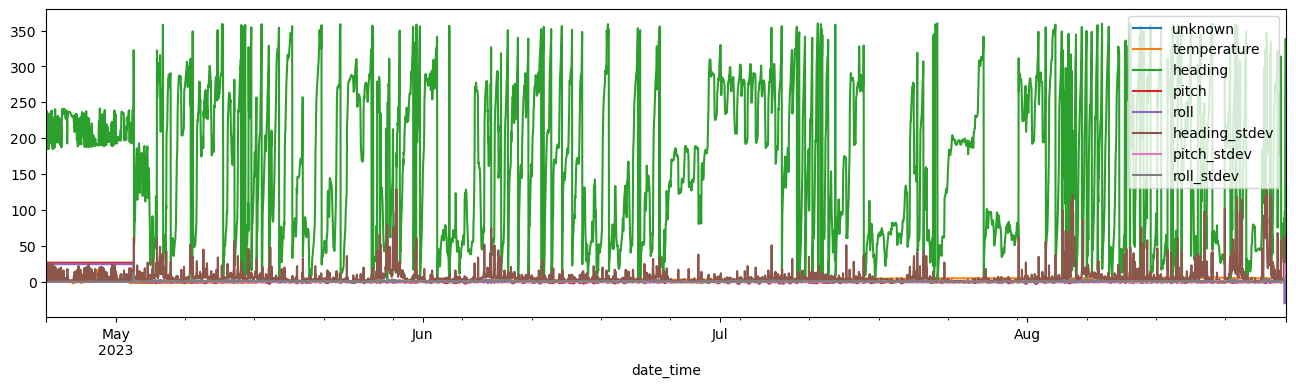

In [91]:
adcp_scal_data.plot(figsize=(16,4))

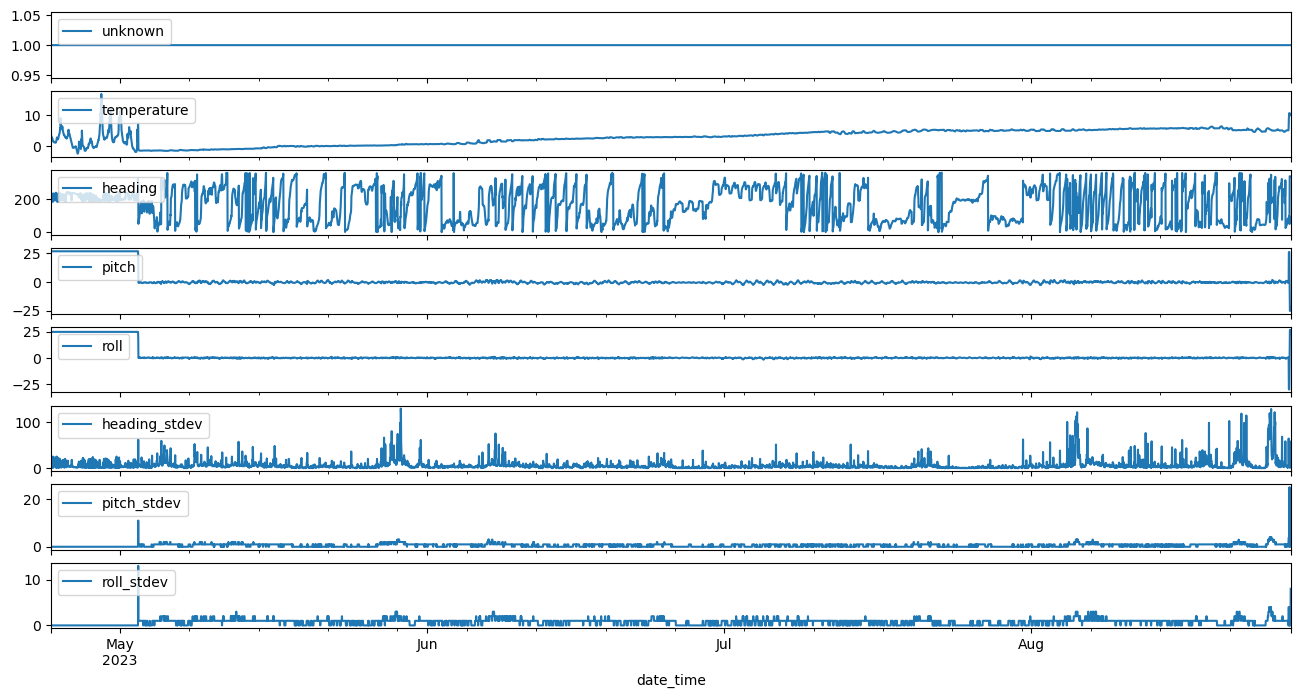

In [92]:
fig, ax = plt.subplots(nrows=len(adcp_scal_data.columns), sharex=True, figsize=(16,8))

for count,parameter in enumerate(adcp_scal_data.columns):
    adcp_scal_data[parameter].plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [93]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [94]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
## Note: EIN and VEL are 2D while scal is 1D.  Combine EIN and VEL into a single file? (more may use the backscatter data)
##  but the scalar data can be treated like any other instrument and will be maintained in a separate file
adcp_wop_nc = ncCFsave.EcoFOCI_CFnc(df=adcp_scal_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname='scal')
adcp_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [95]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
adcp_wop_nc.expand_dimensions()

In [96]:
adcp_wop_nc.variable_meta_data(variable_keys=list(adcp_wop.load_scal_file().columns.values),drop_missing=True)
adcp_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
adcp_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [97]:
#add global attributes
adcp_wop_nc.deployment_meta_add()
adcp_wop_nc.get_xdf()

#add instituitonal global attributes
adcp_wop_nc.institution_meta_add()

#add creation date/time - provenance data
adcp_wop_nc.provinance_meta_add()

#provide intial qc status field
adcp_wop_nc.qc_status(qc_status='unknown')


### Plot Trimmed Data

In [98]:
adcp_wop_nc.autotrim_time().items()

ItemsView(<xarray.Dataset>
Dimensions:        (time: 5574, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2023-05-02T20:30:00 ... 2023-08-26T2...
  * latitude       (latitude) float64 57.72
  * longitude      (longitude) float64 -163.7
  * depth          (depth) float64 41.0
Data variables:
    temperature    (time, depth, latitude, longitude) float64 -0.82 ... 6.21
    heading        (time, depth, latitude, longitude) float64 51.16 ... 73.01
    pitch          (time, depth, latitude, longitude) float64 -0.7 ... -0.39
    roll           (time, depth, latitude, longitude) float64 0.13 0.28 ... 0.76
    heading_stdev  (time, depth, latitude, longitude) int64 5 5 5 8 ... 3 6 4 64
    pitch_stdev    (time, depth, latitude, longitude) int64 1 1 1 1 ... 1 1 1 3
    roll_stdev     (time, depth, latitude, longitude) int64 1 1 1 1 ... 1 1 0 4
Attributes: (12/13)
    Latitude_DegMMddW:                      57 43.016 N
    Longitude_DegMMddN:           

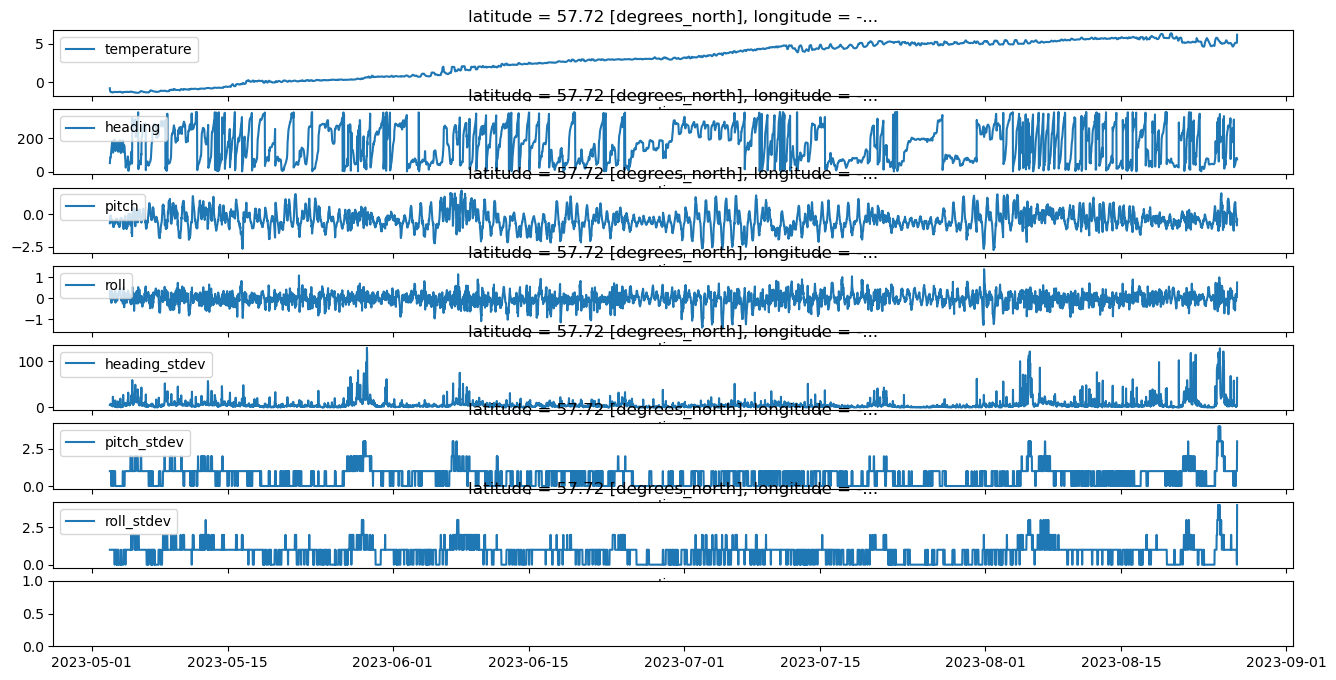

In [99]:
fig, ax = plt.subplots(nrows=len(adcp_scal_data.columns), sharex=True, figsize=(16,8))

count=0
for parameter,values in adcp_wop_nc.autotrim_time().items():
    values.plot(ax=ax[count],label=parameter)
    ax[count].legend(loc='upper left')
    ax[count].set_ylabel('')
    count+=1


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

An untrimmed copy should go in initial_archive (has deck data and is the first simple round of pre-QC)
A trimmed, filtered, filled copy with QA/QC will be derived after

In [116]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)
#adcp_wop_nc.xarray2netcdf_save(xdf = adcp_wop_nc.autotrim_time(),filename='test.nc',format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
inst_shortname = 'scal'
depth = str(int(mooring_config['Instrumentation'][instrument][DepthDescription])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
adcp_wop_nc.xarray2netcdf_save(xdf = adcp_wop_nc.get_xdf(),filename=filename,format="NETCDF4_CLASSIC") #<- if you  would rather keep untrimmed time data
adcp_wop_nc.xarray2netcdf_save(xdf = adcp_wop_nc.autotrim_time(),filename=f'{filename}.trimmed',format="NETCDF4_CLASSIC") #<-- to save a trimmed copy

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})
/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})


In [111]:
adcp_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:        (time: 6009, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time           (time) datetime64[ns] 2023-04-24 ... 2023-08-27T04:00:00
  * latitude       (latitude) float64 57.72
  * longitude      (longitude) float64 -163.7
  * depth          (depth) float64 41.0
Data variables:
    temperature    (time, depth, latitude, longitude) float64 3.32 ... 10.15
    heading        (time, depth, latitude, longitude) float64 231.3 ... 337.1
    pitch          (time, depth, latitude, longitude) float64 26.68 ... -22.54
    roll           (time, depth, latitude, longitude) float64 24.68 ... 23.54
    heading_stdev  (time, depth, latitude, longitude) int64 1 1 2 1 ... 1 2 2 35
    pitch_stdev    (time, depth, latitude, longitude) int64 0 0 0 0 ... 0 0 0 7
    roll_stdev     (time, depth, latitude, longitude) int64 0 0 0 0 ... 0 0 0 8
Attributes: (12/13)
    Latitude_DegMMddW:                      57 43.016 N
    Longitude_DegMMddN:                     163 43.155 W
    MooringID:                              23KUP-1A
    platform_deployment_date:               2023-05-02T20:28:00Z
    platform_deployment_cruise_name:        DY2306
    platform_recovery_date:                 2023-08-26T23:00:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             49.0
    date_created:                           2024-06-06T08:25:41Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

## Do same as above with 2D (EIN & VEL data) - skip most descriptions though

- Historically, FOCI/EPIC standards have kept EIN and Vel data in seperate files.  We will now maintain a single file, but will need to answer the question of QC'ing EIN data

In [112]:
#workds with 2d files same as 1d... just pass a multi-index dataframe in to method
adcp_2D_nc = ncCFsave.EcoFOCI_CFnc(df=adcp_velein_data, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname='')

adcp_2D_nc.get_xdf()

<xarray.Dataset>
Dimensions:          (date_time: 6009, depth: 24)
Coordinates:
  * date_time        (date_time) datetime64[ns] 2023-04-24 ... 2023-08-27T04:...
  * depth            (depth) float64 -9.0 -7.0 -5.0 -3.0 ... 31.0 33.0 35.0 37.0
Data variables:
    u_curr_comp      (date_time, depth) float64 1.144e+04 ... 1.144e+04
    v_curr_comp      (date_time, depth) float64 8.308e+03 ... 8.308e+03
    w_curr_comp      (date_time, depth) float64 nan nan nan nan ... nan nan nan
    w_curr_comp_err  (date_time, depth) float64 nan nan nan nan ... nan nan nan
    agc1             (date_time, depth) int64 42 42 42 42 42 ... 42 42 42 44 53
    agc2             (date_time, depth) int64 42 42 42 42 42 ... 42 42 42 42 41
    agc3             (date_time, depth) int64 44 44 44 44 44 ... 44 44 44 44 53
    agc4             (date_time, depth) int64 38 38 39 38 38 ... 39 39 39 39 38

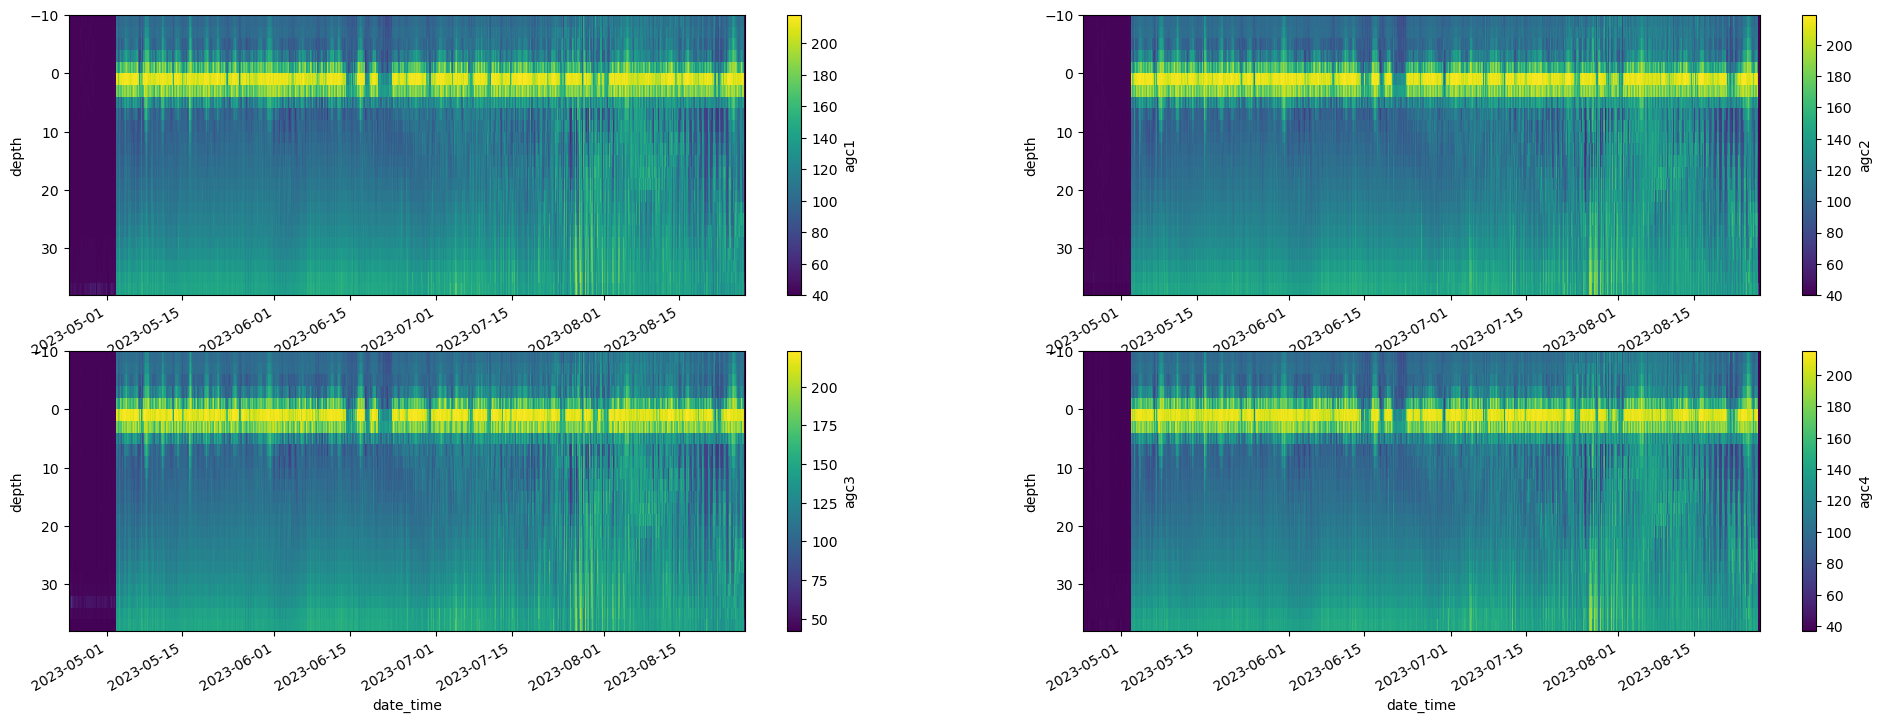

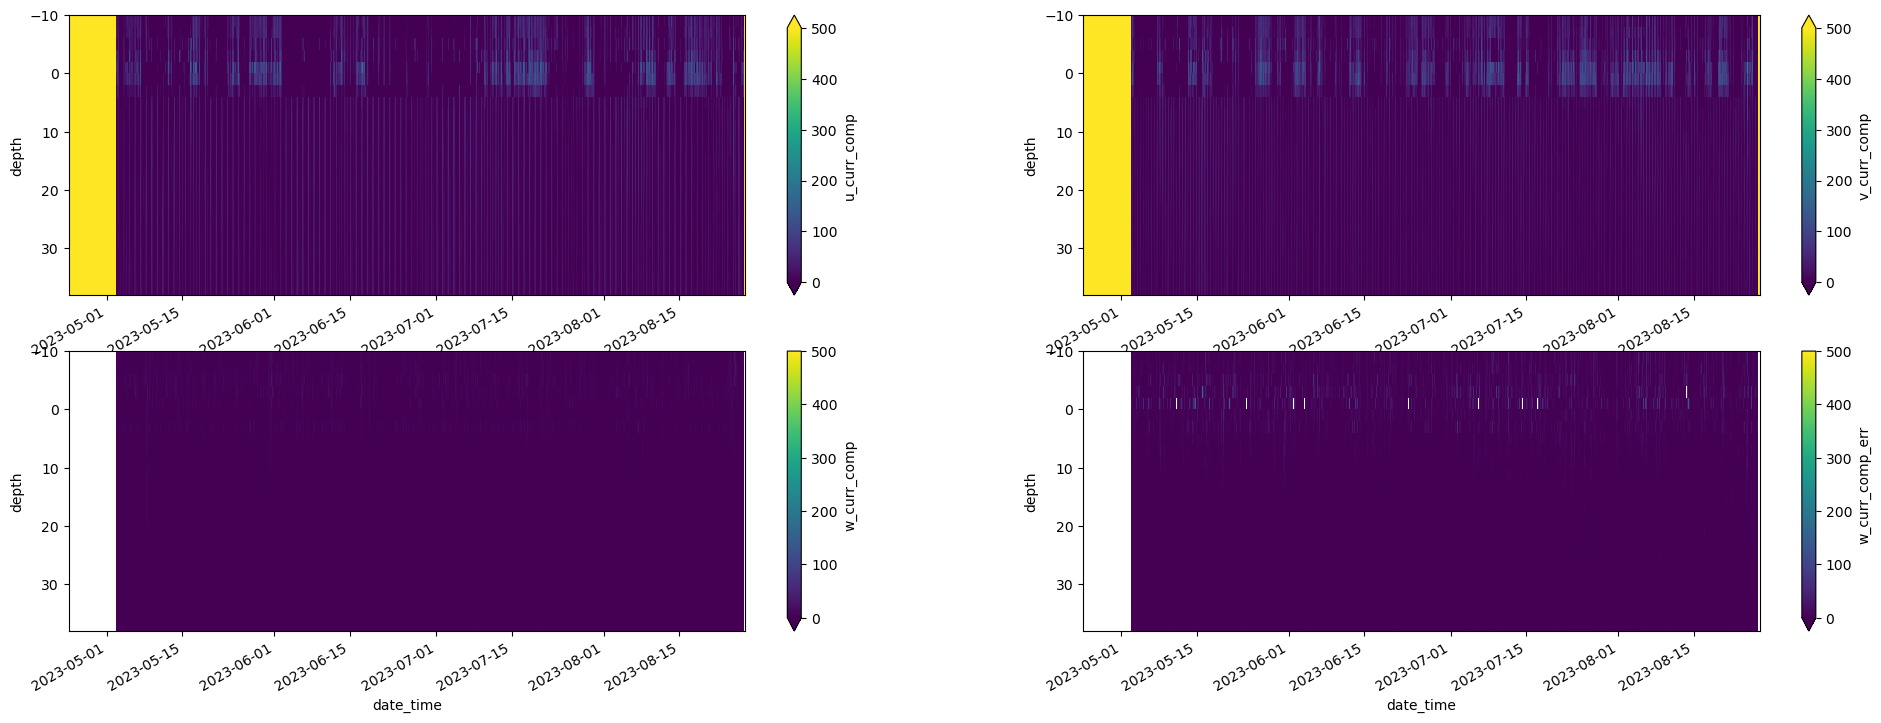

In [103]:
#optional plotting

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    adcp_2D_nc.get_xdf()['agc1'].T.plot(ax=axes[0,0], yincrease=False)
    adcp_2D_nc.get_xdf()['agc2'].T.plot(ax=axes[0,1], yincrease=False)
    adcp_2D_nc.get_xdf()['agc3'].T.plot(ax=axes[1,0], yincrease=False)
    adcp_2D_nc.get_xdf()['agc4'].T.plot(ax=axes[1,1], yincrease=False)
except:
    pass

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    adcp_2D_nc.get_xdf()['u_curr_comp'].T.plot(ax=axes[0,0],vmin=0, vmax=500, yincrease=False)
    adcp_2D_nc.get_xdf()['v_curr_comp'].T.plot(ax=axes[0,1],vmin=0, vmax=500, yincrease=False)
    adcp_2D_nc.get_xdf()['w_curr_comp'].T.plot(ax=axes[1,0],vmin=0, vmax=500, yincrease=False)
    adcp_2D_nc.get_xdf()['w_curr_comp_err'].T.plot(ax=axes[1,1],vmin=0, vmax=500, yincrease=False)
except:
    pass

In [104]:
adcp_2D_nc.get_xdf()

<xarray.Dataset>
Dimensions:          (date_time: 6009, depth: 24)
Coordinates:
  * date_time        (date_time) datetime64[ns] 2023-04-24 ... 2023-08-27T04:...
  * depth            (depth) float64 -9.0 -7.0 -5.0 -3.0 ... 31.0 33.0 35.0 37.0
Data variables:
    u_curr_comp      (date_time, depth) float64 1.144e+04 ... 1.144e+04
    v_curr_comp      (date_time, depth) float64 8.308e+03 ... 8.308e+03
    w_curr_comp      (date_time, depth) float64 nan nan nan nan ... nan nan nan
    w_curr_comp_err  (date_time, depth) float64 nan nan nan nan ... nan nan nan
    agc1             (date_time, depth) int64 42 42 42 42 42 ... 42 42 42 44 53
    agc2             (date_time, depth) int64 42 42 42 42 42 ... 42 42 42 42 41
    agc3             (date_time, depth) int64 44 44 44 44 44 ... 44 44 44 44 53
    agc4             (date_time, depth) int64 38 38 39 38 38 ... 39 39 39 39 38

In [113]:
adcp_2D_nc.expand_dimensions(dim_names=['latitude','longitude'],geophys_sort=False)
adcp_2D_nc.variable_meta_data(variable_keys=list(adcp_velein_data.columns.values),drop_missing=True)
adcp_2D_nc.temporal_geospatioal_meta_data(depth='adcp') #passing adcp skips adding record data to adcp 2d variable
#adding dimension meta needs to come after updating the dimension values... BUG?
adcp_2D_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

#add global attributes
adcp_2D_nc.deployment_meta_add()

#add instituitonal global attributes
adcp_2D_nc.institution_meta_add()

#add creation date/time - provenance data
adcp_2D_nc.provinance_meta_add()

#provide intial qc status field
adcp_2D_nc.qc_status(qc_status='unknown')

depth = str(int(mooring_config['Instrumentation'][instrument][DepthDescription])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+depth+'m.nc'
adcp_2D_nc.xarray2netcdf_save(xdf = adcp_2D_nc.autotrim_time(),filename=filename,format="NETCDF4_CLASSIC") #<- if you  would rather keep untrimmed time data
#adcp_2D_nc.xarray2netcdf_save(xdf = adcp_2D_nc.autotrim_time(),filename=filename.replace('.nc','.trimmed.nc'),format="NETCDF4_CLASSIC")
                    

no change to depth variable


/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})


In [114]:
adcp_2D_nc.autotrim_time()

<xarray.Dataset>
Dimensions:          (time: 5574, depth: 24, latitude: 1, longitude: 1)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-02T20:30:00 ... 2023-08-26...
  * depth            (depth) float64 -9.0 -7.0 -5.0 -3.0 ... 31.0 33.0 35.0 37.0
  * latitude         (latitude) float64 57.72
  * longitude        (longitude) float64 -163.7
Data variables:
    u_curr_comp      (latitude, longitude, time, depth) float64 24.69 ... 3.614
    v_curr_comp      (latitude, longitude, time, depth) float64 17.75 ... 0.4388
    w_curr_comp      (latitude, longitude, time, depth) float64 -4.7 ... -0.2
    w_curr_comp_err  (latitude, longitude, time, depth) float64 -7.9 ... -1.4
    agc1             (latitude, longitude, time, depth) int64 103 107 ... 105
    agc2             (latitude, longitude, time, depth) int64 103 105 ... 105
    agc3             (latitude, longitude, time, depth) int64 108 111 ... 110
    agc4             (latitude, longitude, time, depth) int64 102 106 ... 103
Attributes: (12/13)
    Latitude_DegMMddW:                      57 43.016 N
    Longitude_DegMMddN:                     163 43.155 W
    MooringID:                              23KUP-1A
    platform_deployment_date:               2023-05-02T20:28:00Z
    platform_deployment_cruise_name:        DY2306
    platform_recovery_date:                 2023-08-26T23:00:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  
    WaterDepth:                             49.0
    date_created:                           2024-06-06T08:33:41Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.\nTrimmed t...

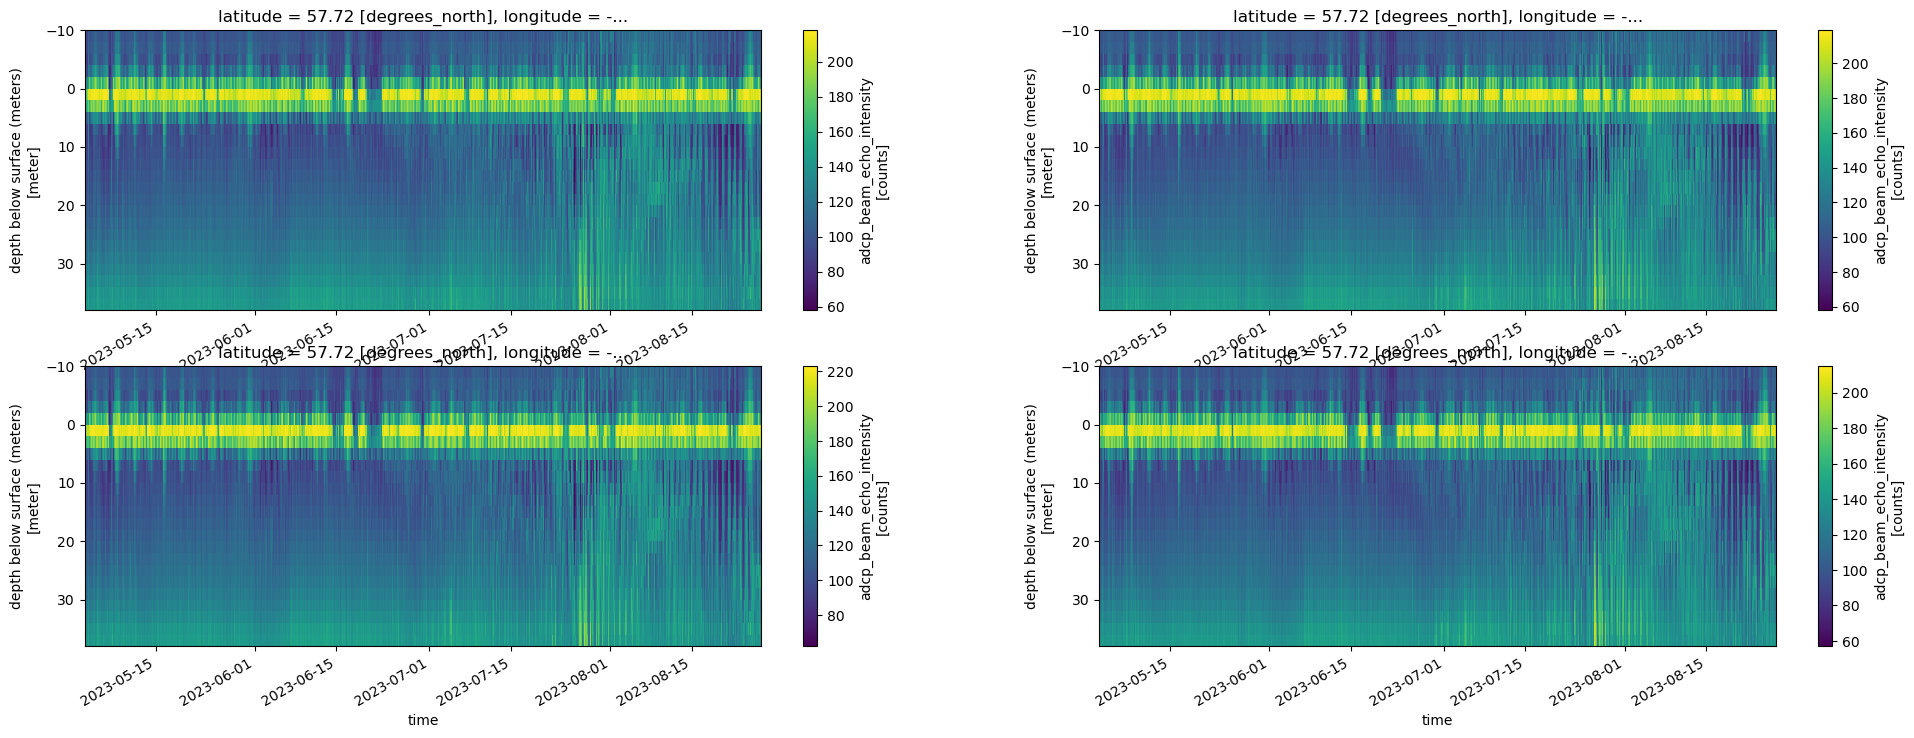

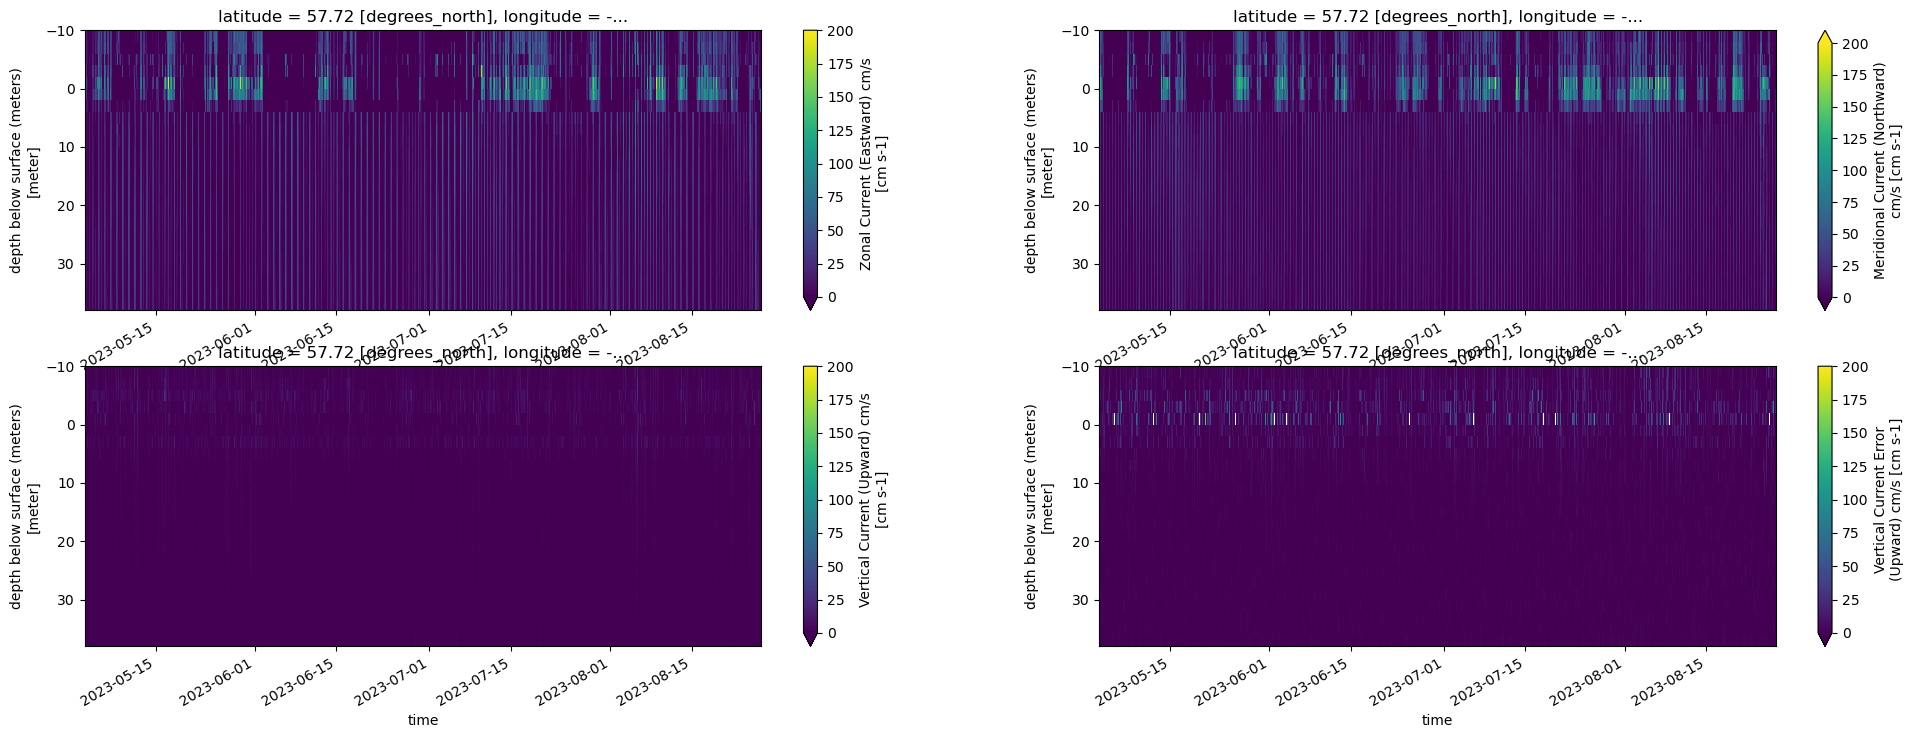

In [115]:
#optional plotting

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    adcp_2D_nc.autotrim_time()['agc1'].T.plot(ax=axes[0,0], yincrease=False)
    adcp_2D_nc.autotrim_time()['agc2'].T.plot(ax=axes[0,1], yincrease=False)
    adcp_2D_nc.autotrim_time()['agc3'].T.plot(ax=axes[1,0], yincrease=False)
    adcp_2D_nc.autotrim_time()['agc4'].T.plot(ax=axes[1,1], yincrease=False)
except:
    pass

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24,8))
try:
    adcp_2D_nc.autotrim_time()['u_curr_comp'].T.plot(ax=axes[0,0],vmin=0, vmax=200, yincrease=False)
    adcp_2D_nc.autotrim_time()['v_curr_comp'].T.plot(ax=axes[0,1],vmin=0, vmax=200, yincrease=False)
    adcp_2D_nc.autotrim_time()['w_curr_comp'].T.plot(ax=axes[1,0],vmin=0, vmax=200, yincrease=False)
    adcp_2D_nc.autotrim_time()['w_curr_comp_err'].T.plot(ax=axes[1,1],vmin=0, vmax=200, yincrease=False)
except:
    pass

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- see [EcoFOCIpy_2D_filter_example.ipynb](EcoFOCIpy_2D_filter_example.ipynb) for how to apply a lanzcos filter to each depth and return usable results
- see [EcoFOCIpy_ADCP_QC_example.ipynb](EcoFOCIpy_ADCP_QC_example.ipynb) for how to apply basic ADCP QC (beyond adjusting the depth and trimming times which you've already done).  The additional QC may involve removing bins above surface